# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [2]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import math

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [ ]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=1.4,
                maxmagnitude=1.69,
                maxradiuskm=100, 
                latitude=47.60,
                longitude=-122.33)

print("Returned %s events" % len(events))
 
 

### Choose an event to analyze

In [ ]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df


#event_df.iloc[0::]

In [ ]:
#just save 600 km (3 to 5 mw earthquakes)
dist_kmarray = []
magnituddarray = []


In [ ]:
#just save between 700 and 600km (2.77 to 5 mw earthquakes)
dist_kmarray2 = []
magnituddarray2 = []
distancerangeradius = []

In [ ]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    

    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    #print(distance)
    
    #if  dist_km  <601:#if when I want to avoid the previus datas
       # continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    dist_kmarray.append(dist_km)
    #distancerangeradius.append(distance)
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
           f"{this_event_new['location'].to_numpy()[0]}, "\
           f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      

        
    cable = 'whidbey'
    record_length = 5 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
         
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                            t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']

        low_cut = 2
        hi_cut = 10

        b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        data_filt = filtfilt(b,a,data,axis=0)
        try:
            client = Client("IRIS")

            t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
            dt = datetime.timedelta(minutes=record_length)
            t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

            st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
            st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
            st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

            pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
            st.remove_response(output='VEL', pre_filt=pre_filt)
            st2.remove_response(output='VEL', pre_filt=pre_filt)
            filename = f"earthquakes169to14/"+this_id
            local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                       stitle,filename=filename,das_vmax=0.5,
                         network_name=network_name,
                         skip_seismograms=False)
    
        except Exception as e:
                print(str(e))
        continue
   
    except ValueError:
            continue



In [ ]:
event_df.id[60:]#len(distancerangeradius)

In [7]:
df0=pd.read_csv('Catalogo600km3to5mw.csv')
df0
df=pd.read_csv('Catalog-Whidbey-lowmagnitud.csv')  
df
dff1=pd.read_csv('Catalogwhidbey24to27.csv')
dff1
dff2=pd.read_csv('whidbeyhiguestamplitudin1000.csv')
dff3=pd.read_csv('Catalogwhidbey24to27.csv')
dff3
dff4=pd.read_csv('Catalogwhidbey239to20.csv')
dff4
dff5=pd.read_csv('Catalogwhidbey199to17.csv')
dff6=pd.read_csv('Catalogwhidbey169to14.csv')
dff7=pd.read_csv('Catalogwhidbeyglobal67plus.csv')

In [8]:
selected_rows0 = df0[df0.detect_das == 'TRUE']
noselected_rows0 = df0[df0.detect_das == 'FALSE']
selected_rows1 = dff1[dff1.detect_das == 'TRUE']
noselected_rows1 = dff1[dff1.detect_das == 'FALSE']
selected_rows = df[df.detect_das == 'TRUE']
noselected_rows = df[df.detect_das == 'FALSE']
selected_rows2 = dff2[dff2.detect_das == 'TRUE']
noselected_rows2 = dff2[dff2.detect_das == 'FALSE']
selected_rows3 = dff3[dff3.detect_das == 'TRUE']
noselected_rows3 = dff3[dff3.detect_das == 'FALSE']
selected_rows4 = dff4[dff4.detect_das == 'TRUE']
noselected_rows4 = dff4[dff4.detect_das == 'FALSE']
selected_rows5 = dff5[dff5.detect_das == 'TRUE']
noselected_rows5 = dff5[dff5.detect_das == 'FALSE']
selected_rows6 = dff6[dff6.detect_das == 'TRUE']
noselected_rows6 = dff6[dff6.detect_das == 'FALSE']
selected_rows7 = dff7[dff7.detect_das == 'TRUE']
noselected_rows7 = dff7[dff7.detect_das == 'FALSE']
#plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('log10(Distance to the cable(Km))')
#plt.ylabel('Magnitud')
#plt.title('Whidbey detection (magnitudes between 2.7 to 2.99 mw)')
#plt.grid()
#plt.savefig("whidbeylocalquakes-lowmagnitud")
#plt.show()
#plt.close()

In [ ]:
#plot testing
#creating plot distance vs magnitud
#plt.subplots(figsize=(10,5))
#plt.scatter(np.log10(dist_kmarray), magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
#plt.xlabel('Distance to the cable [Km]')
#plt.ylabel('Earthquakes magnitud');
#plt.legend()
#plt.grid()
#plt.show()

# Data frame for earthquakes with WhibdeyCable

In [ ]:
#these lines replaced for df0 folder
#tf=['False','False','True','True','norecord','True','False','True','True','True','False','True','True','False','False','False','False','False','False','True','Norecord','Norecord','False','True','Norecord','Norecord','True','False']
#tfn=np.array(tf).T
#len(tf)
#dataf = np.array([event_df.id, event_df.location, event_df.magnitude,tf],dtype='object').T
#dataf
#df3 = pd.DataFrame(dataf,columns=['Id', 'Distance', 'Magnitude','Detected by Das'])
#df3



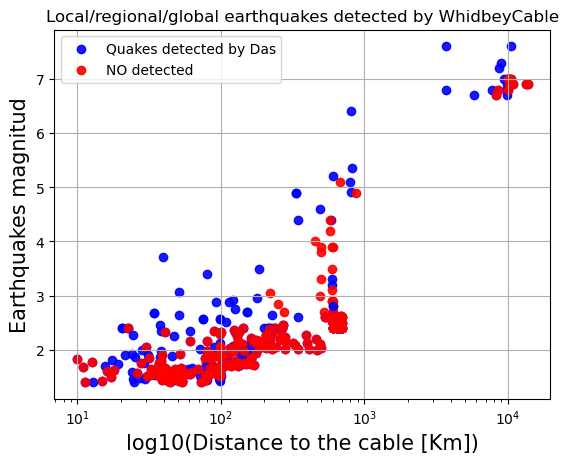

In [14]:
#creating plot distance vs magnitud (real earthquakes that we can see)
#newmagtnitud=[magnituddarray[2],magnituddarray[3],magnituddarray[5],magnituddarray[7],magnituddarray[8],magnituddarray[10],magnituddarray[11],magnituddarray[13],magnituddarray[14],magnituddarray[18],magnituddarray[19],magnituddarray[23],magnituddarray[26]]
#newdist_kmarray=[dist_kmarray[2],dist_kmarray[3],dist_kmarray[5],dist_kmarray[7],dist_kmarray[8],dist_kmarray[10],dist_kmarray[11],dist_kmarray[13],dist_kmarray[14],dist_kmarray[18],dist_kmarray[19],dist_kmarray[23],dist_kmarray[26]]
#filename = f"earthquakes_distances600noseismogramswhidbey/"
figure=plt.plot(figsize=(15,20))
plt.scatter(selected_rows0.Location,selected_rows0.Magnitud,c='b', s=None, marker='o', alpha=0.9, label='Quakes detected by Das')
plt.scatter(noselected_rows0.Location,noselected_rows0.Magnitud,c='r', s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 3.0mw No detected')
#plt.scatter(newdist_kmarray,newmagtnitud,s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 3.0mw')
plt.scatter(noselected_rows.Location,noselected_rows.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 2.7 to 3mw NO DETECTED')
plt.scatter(selected_rows.Location,selected_rows.Magnitud,c='b',s=None, marker='o', alpha=0.9) # label='Earthquakes magnitud from 2.7 to 3mw')
plt.scatter(selected_rows1.Location,selected_rows1.Magnitud,c='b',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 1.5 to 2.7mw')
plt.scatter(noselected_rows1.Location,noselected_rows1.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='nodetected Earthquakes magnitud from 1.5 to 2.7mw')
#plt.scatter(dff2.Location,dff2.Magnitud,c='b',s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(selected_rows2.Location,selected_rows2.Magnitud,c='b',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows2.Location,noselected_rows2.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='no detected Earthquakes ')
plt.scatter(dff3.Location,dff3.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows3.Location,noselected_rows3.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(dff4.Location,dff4.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows4.Location,noselected_rows4.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(dff5.Location,dff5.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows5.Location,noselected_rows5.Magnitud,c='r',s=None, marker='o', alpha=0.9)# label='Earthquakes pequeños')
plt.scatter(dff6.Location,dff6.Magnitud,c='b',s=None, marker='o', alpha=0.9)#, label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows6.Location,noselected_rows6.Magnitud,c='r',s=None, marker='o', alpha=0.9)
plt.scatter(dff7.Location,dff7.Magnitud,c='b',s=None, marker='o', alpha=0.9)# label='Earthquakes magnitud from 4.9 to 8mw')
plt.scatter(noselected_rows7.Location,noselected_rows7.Magnitud,c='r',s=None, marker='o', alpha=0.9,label='NO detected')
plt.title('Local/regional/global earthquakes detected by WhidbeyCable')
plt.xscale('log')
plt.xlabel('log10(Distance to the cable [Km])',fontsize=15)
plt.ylabel('Earthquakes magnitud', fontsize=15);
plt.legend()
plt.grid()
#plt.savefig(filename+"_whidbeylocalquakes")
plt.savefig("whidbeylocalquakesmw")
plt.show()
plt.close()

In [ ]:
plt.scatter(selected_rows3.Location,selected_rows3.Magnitud,c='b',s=None, marker='o', alpha=0.9, label='Earthquakes magnitud from 4.9 to 8mw')